#1 Small-size Datasets

This is image data of Natural Scenes around the world.

This Data contains around 25k images of size 150x150 distributed under 6 categories.
{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.
This data was initially published on https://datahack.analyticsvidhya.com by Intel to host a Image classification Challenge.

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.transforms import transforms, autoaugment
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
%matplotlib inline
from torchvision.datasets import ImageFolder

In [2]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"longwei123","key":"753b9d3ccb5a72fafed9c0e1b3956402"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle datasets download -d puneet6060/intel-image-classification

 95% 329M/346M [00:11<00:00, 36.1MB/s]
100% 346M/346M [00:11<00:00, 32.7MB/s]


In [4]:
!unzip intel-image-classification -d data_set

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: data_set/seg_train/seg_train/mountain/7506.jpg  
  inflating: data_set/seg_train/seg_train/mountain/7537.jpg  
  inflating: data_set/seg_train/seg_train/mountain/7539.jpg  
  inflating: data_set/seg_train/seg_train/mountain/7551.jpg  
  inflating: data_set/seg_train/seg_train/mountain/7560.jpg  
  inflating: data_set/seg_train/seg_train/mountain/7565.jpg  
  inflating: data_set/seg_train/seg_train/mountain/7578.jpg  
  inflating: data_set/seg_train/seg_train/mountain/7581.jpg  
  inflating: data_set/seg_train/seg_train/mountain/7586.jpg  
  inflating: data_set/seg_train/seg_train/mountain/7647.jpg  
  inflating: data_set/seg_train/seg_train/mountain/7652.jpg  
  inflating: data_set/seg_train/seg_train/mountain/7654.jpg  
  inflating: data_set/seg_train/seg_train/mountain/7662.jpg  
  inflating: data_set/seg_train/seg_train/mountain/767.jpg  
  inflating: data_set/seg_train/seg_train/mountain/7672.jpg  
  inflating: data_set/seg_train/seg_train/mo

In [5]:
def get_mean_std(dataset, ratio=0.1):
    """Get mean and std by sample ratio
    """
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=int(len(dataset)*ratio), 
                                             shuffle=True, num_workers=10)
    train = iter(dataloader).next()[0]  
    mean = np.mean(train.numpy(), axis=(0,2,3))
    std = np.std(train.numpy(), axis=(0,2,3))
    return mean, std
train_data_dir  = '/content/data_set/seg_train/seg_train'
transformationtrain = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
 ])
train_dataset = ImageFolder(train_data_dir, transform = transformationtrain)
train_mean, train_std = get_mean_std(train_dataset)
print(train_mean, train_std)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[0.42939582 0.45776138 0.4562974 ] [0.26003543 0.25943154 0.29206985]


In [18]:
train_data_dir  = '/content/data_set/seg_train/seg_train'
data_norm_mean = train_mean
data_norm_std = train_std
transformationtrain = transforms.Compose([
    transforms.Resize((280,280)),
    transforms.RandomResizedCrop(224, scale=(0.64, 1.0), ratio=(1.0, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_norm_mean, std=data_norm_std)
 ])
train_data = ImageFolder(train_data_dir, transform = transformationtrain)

In [20]:
val_data_dir  = '/content/data_set/seg_test/seg_test'
transformationtest = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_norm_mean, std=data_norm_std)
 ])
val_data = ImageFolder(val_data_dir, transform = transformationtest)
# val_data, test_data = random_split(val_data, [1500, 1500])

In [21]:
trainDataLoader = torch.utils.data.DataLoader(train_data,batch_size=32,shuffle=True)
valDataLoader = torch.utils.data.DataLoader(val_data,batch_size=32,shuffle=False)
testDataLoader = torch.utils.data.DataLoader(val_data,batch_size=32,shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


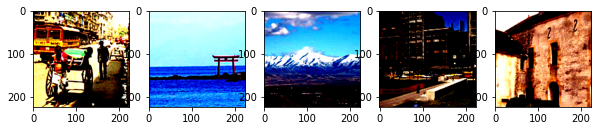

In [22]:
images, labels = iter(trainDataLoader).next()

plt.figure(figsize=(10,4))
for index in np.arange(0,5):
  plt.subplot(1,5,index+1)
  plt.imshow(np.stack((images[index][0], images[index][1], images[index][2]), axis=2))

In [10]:
def trains(epochs, model, lr, save_loss, save_acc, trainDataLoader, valDataLoader):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)
  save_loss = save_loss
  save_acc = save_acc
  trainDataLoader = trainDataLoader
  testDataLoader = valDataLoader
  for epoch in range(epochs):
    model.train()
    current_loss = 0.0
    current_corrects = 0
    for batch_idx, (inputs, labels) in enumerate(trainDataLoader):
      # print(batch_idx)
      inputs = inputs.cuda()
      labels = labels.cuda()
      model.cuda()
      optimizer.zero_grad()

      with torch.set_grad_enabled(True):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
      
      current_loss += loss.item() * inputs.size(0)
      current_corrects += torch.sum(preds == labels.data)

    save_loss['train'] += [current_loss / len(trainDataLoader.dataset)]
    save_acc['train'] += [current_corrects.float() / len(trainDataLoader.dataset)]
    # pretty print
    print(f"Epoch:{epoch} -- Phase:{'train'} -- Loss:{save_loss['train'][-1]:.2f} -- Acc:{save_acc['train'][-1]*100:.2f}")

    model.eval()
    current_loss = 0.0
    current_corrects = 0
    for batch_idx, (inputs, labels) in enumerate(testDataLoader):
      # print(batch_idx)
      inputs = inputs.cuda()
      labels = labels.cuda()
      optimizer.zero_grad()

      with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

      current_loss += loss.item() * inputs.size(0)
      current_corrects += torch.sum(preds == labels.data)

    save_loss['val'] += [current_loss / len(testDataLoader.dataset)]
    save_acc['val'] += [current_corrects.float() / len(testDataLoader.dataset)]
    # pretty print
    print(f"Epoch:{epoch} -- Phase:{'val'} -- Loss:{save_loss['val'][-1]:.2f} -- Acc:{save_acc['val'][-1]*100:.2f}")


In [11]:
def tests(model, test_loss, test_acc, testDataLoader):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=5.5e-5)
  model.eval()
  current_loss = 0.0
  current_corrects = 0
  for batch_idx, (inputs, labels) in enumerate(testDataLoader):
    inputs = inputs.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()

    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)

    current_loss += loss.item() * inputs.size(0)
    current_corrects += torch.sum(preds == labels.data)

  test_loss = current_loss / len(testDataLoader.dataset)
  test_acc = current_corrects.float() / len(testDataLoader.dataset)
  # pretty print
  print(f"Epoch:{1} -- Phase:{'test'} -- Loss:{test_loss:.2f} -- Acc:{test_acc*100:.2f}")

#2 Training small-size dataset to get higher accuracy

##2.1 using non-pretrained models

###2.1.1 non-pretrained Resnet50 model

In [82]:
model_res_nonpre = torchvision.models.resnet50(pretrained=False).cuda()

In [83]:
num_ftrs = model_res_nonpre.fc.in_features
model_res_nonpre.fc = nn.Linear(num_ftrs, 6)

In [84]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [85]:
print(count_parameters(model_res_nonpre))

23520326


In [86]:
save_loss1 = {'train':[], 'val':[]}
save_acc1 = {'train':[], 'val':[]}

In [87]:
epoches = 20
trains(epoches, model_res_nonpre, 5.5e-5, save_loss1, save_acc1, trainDataLoader, valDataLoader)

Epoch:0 -- Phase:train -- Loss:1.15 -- Acc:54.42
Epoch:0 -- Phase:val -- Loss:1.40 -- Acc:52.87
Epoch:1 -- Phase:train -- Loss:0.88 -- Acc:66.80
Epoch:1 -- Phase:val -- Loss:0.76 -- Acc:72.03
Epoch:2 -- Phase:train -- Loss:0.73 -- Acc:72.67
Epoch:2 -- Phase:val -- Loss:0.72 -- Acc:73.33
Epoch:3 -- Phase:train -- Loss:0.67 -- Acc:75.34
Epoch:3 -- Phase:val -- Loss:0.63 -- Acc:76.70
Epoch:4 -- Phase:train -- Loss:0.61 -- Acc:77.36
Epoch:4 -- Phase:val -- Loss:0.63 -- Acc:76.43
Epoch:5 -- Phase:train -- Loss:0.56 -- Acc:79.16
Epoch:5 -- Phase:val -- Loss:0.55 -- Acc:79.63
Epoch:6 -- Phase:train -- Loss:0.53 -- Acc:80.70
Epoch:6 -- Phase:val -- Loss:0.54 -- Acc:80.50
Epoch:7 -- Phase:train -- Loss:0.51 -- Acc:82.00
Epoch:7 -- Phase:val -- Loss:0.50 -- Acc:82.40
Epoch:8 -- Phase:train -- Loss:0.48 -- Acc:82.56
Epoch:8 -- Phase:val -- Loss:0.52 -- Acc:80.63
Epoch:9 -- Phase:train -- Loss:0.45 -- Acc:84.12
Epoch:9 -- Phase:val -- Loss:0.48 -- Acc:82.47
Epoch:10 -- Phase:train -- Loss:0.42 -- 

In [89]:
# save model
model_path = './project2_Res50_final_smalldataset.pt'
torch.save(model_res_nonpre.state_dict(), model_path)

###2.1.2 non-pretrained Vit-base model

In [41]:
!pip install einops

In [75]:
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [76]:
model_vit_nonpre = ViT(
    image_size = 224,
    patch_size = 16,
    num_classes = 6,
    dim = 768,
    depth = 6,
    heads = 12,
    mlp_dim = 1536,
    dropout = 0.1,
    emb_dropout = 0.1
)

In [77]:
model_vit_nonpre = model_vit_nonpre.cuda()

In [78]:
print(count_parameters(model_vit_nonpre))

29097222


In [79]:
save_loss2 = {'train':[], 'val':[]}
save_acc2 = {'train':[], 'val':[]}

In [80]:
trains(epoches, model_vit_nonpre, 5.5e-5, save_loss2, save_acc2, trainDataLoader, valDataLoader)

Epoch:0 -- Phase:train -- Loss:1.13 -- Acc:55.61
Epoch:0 -- Phase:val -- Loss:0.86 -- Acc:67.23
Epoch:1 -- Phase:train -- Loss:0.80 -- Acc:70.36
Epoch:1 -- Phase:val -- Loss:0.72 -- Acc:74.80
Epoch:2 -- Phase:train -- Loss:0.73 -- Acc:73.33
Epoch:2 -- Phase:val -- Loss:0.65 -- Acc:76.77
Epoch:3 -- Phase:train -- Loss:0.67 -- Acc:75.45
Epoch:3 -- Phase:val -- Loss:0.62 -- Acc:76.83
Epoch:4 -- Phase:train -- Loss:0.62 -- Acc:77.13
Epoch:4 -- Phase:val -- Loss:0.58 -- Acc:78.73
Epoch:5 -- Phase:train -- Loss:0.59 -- Acc:78.23
Epoch:5 -- Phase:val -- Loss:0.58 -- Acc:79.27
Epoch:6 -- Phase:train -- Loss:0.57 -- Acc:78.77
Epoch:6 -- Phase:val -- Loss:0.53 -- Acc:80.97
Epoch:7 -- Phase:train -- Loss:0.53 -- Acc:80.83
Epoch:7 -- Phase:val -- Loss:0.57 -- Acc:80.33
Epoch:8 -- Phase:train -- Loss:0.53 -- Acc:80.54
Epoch:8 -- Phase:val -- Loss:0.52 -- Acc:81.17
Epoch:9 -- Phase:train -- Loss:0.50 -- Acc:81.67
Epoch:9 -- Phase:val -- Loss:0.49 -- Acc:82.67
Epoch:10 -- Phase:train -- Loss:0.48 -- 

In [90]:
# save model
model_path = './project2_VitBase_final_smalldataset.pt'
torch.save(model_vit_nonpre.state_dict(), model_path)

###2.1.3 non-pretrained SPT+LSA+Vit model

In [59]:
# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class LSA(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.temperature = nn.Parameter(torch.log(torch.tensor(dim_head ** -0.5)))

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.temperature.exp()

        mask = torch.eye(dots.shape[-1], device = dots.device, dtype = torch.bool)
        mask_value = -torch.finfo(dots.dtype).max
        dots = dots.masked_fill(mask, mask_value)

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, LSA(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class SPT(nn.Module):
    def __init__(self, *, dim, patch_size, channels = 3):
        super().__init__()
        patch_dim = patch_size * patch_size * 5 * channels

        self.to_patch_tokens = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim)
        )

    def forward(self, x):
        shifts = ((1, -1, 0, 0), (-1, 1, 0, 0), (0, 0, 1, -1), (0, 0, -1, 1))
        shifted_x = list(map(lambda shift: F.pad(x, shift), shifts))
        x_with_shifts = torch.cat((x, *shifted_x), dim = 1)
        return self.to_patch_tokens(x_with_shifts)

class ViT1(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = SPT(dim = dim, patch_size = patch_size, channels = channels)

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [60]:
model_lsv_nonpre = ViT1(
    image_size = 224,
    patch_size = 16,
    num_classes = 6,
    dim = 768,
    depth = 6,
    heads = 12,
    mlp_dim = 1536,
    dropout = 0.1,
    emb_dropout = 0.1
)

In [61]:
model_lsv_nonpre = model_lsv_nonpre.cuda()

In [62]:
print(count_parameters(model_lsv_nonpre))

31464204


In [91]:
print(model_lsv_nonpre)

ViT1(
  (to_patch_embedding): SPT(
    (to_patch_tokens): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
      (1): LayerNorm((3840,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=3840, out_features=768, bias=True)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (fn): LSA(
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.1, inplace=False)
            (to_qkv): Linear(in_features=768, out_features=2304, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=768, out_features=768, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (fn): FeedFo

In [63]:
save_loss3 = {'train':[], 'val':[]}
save_acc3 = {'train':[], 'val':[]}

In [64]:
trains(epoches, model_lsv_nonpre, 5.5e-5, save_loss3, save_acc3, trainDataLoader, valDataLoader)

Epoch:0 -- Phase:train -- Loss:1.01 -- Acc:59.63
Epoch:0 -- Phase:val -- Loss:0.75 -- Acc:71.30
Epoch:1 -- Phase:train -- Loss:0.71 -- Acc:73.44
Epoch:1 -- Phase:val -- Loss:0.65 -- Acc:75.50
Epoch:2 -- Phase:train -- Loss:0.64 -- Acc:76.36
Epoch:2 -- Phase:val -- Loss:0.60 -- Acc:77.60
Epoch:3 -- Phase:train -- Loss:0.59 -- Acc:78.09
Epoch:3 -- Phase:val -- Loss:0.54 -- Acc:80.67
Epoch:4 -- Phase:train -- Loss:0.56 -- Acc:79.42
Epoch:4 -- Phase:val -- Loss:0.52 -- Acc:80.67
Epoch:5 -- Phase:train -- Loss:0.54 -- Acc:79.86
Epoch:5 -- Phase:val -- Loss:0.52 -- Acc:81.47
Epoch:6 -- Phase:train -- Loss:0.52 -- Acc:80.41
Epoch:6 -- Phase:val -- Loss:0.53 -- Acc:80.33
Epoch:7 -- Phase:train -- Loss:0.50 -- Acc:81.55
Epoch:7 -- Phase:val -- Loss:0.51 -- Acc:81.93
Epoch:8 -- Phase:train -- Loss:0.49 -- Acc:81.50
Epoch:8 -- Phase:val -- Loss:0.53 -- Acc:81.43
Epoch:9 -- Phase:train -- Loss:0.48 -- Acc:82.33
Epoch:9 -- Phase:val -- Loss:0.48 -- Acc:82.10
Epoch:10 -- Phase:train -- Loss:0.46 -- 

In [92]:
# save model
model_path = './project2_SLVit_final_smalldataset.pt'
torch.save(model_lsv_nonpre.state_dict(), model_path)

###2.1.4 non-pretrained Resnet+Vit model

In [67]:
class BasicBlock(nn.Module):
    # expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, input):
        residual = input
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.downsample:
            residual = self.downsample(residual)
        x += residual
        x = self.relu(x)
        return x

class Resnet(nn.Module):
    # 32*32
    # def __init__(self, block, num_layer, n_classes=10, input_channels=3):
    def __init__(self, block, num_layer, input_channels=3):
        super(Resnet, self).__init__()
        self.in_channels = 147
        self.conv1 = nn.Conv2d(input_channels, 147, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(147)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 147, num_layer[0])
        self.layer2 = self._make_layer(block, 294, num_layer[1], 2)
        self.layer3 = self._make_layer(block, 588, num_layer[2], 2)
        # self.layer4 = self._make_layer(block, 336, num_layer[3], 2)
        # self.avgpool = nn.AvgPool2d(kernel_size=4, stride=1)
        # self.fc = nn.Linear(336, n_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)


    def _make_layer(self, block, out_channels, num_block, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, num_block):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # x = self.layer4(x)
        
        # x = self.avgpool(x)
        # x = x.view(x.size(0), -1)
        # x = self.fc(x)
        return x

def resnet_modify(**kwargs):
    """Constructs a ResNet-18 model.

    """
    x = Resnet(BasicBlock, [2, 2, 2], **kwargs)
    return x

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT_M(nn.Module):
    def __init__(self, *, patch_size = 14, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 588, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        # image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        # assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        # num_patches = (image_height // patch_height) * (image_width // patch_width)
        num_patches = channels // 3
        # patch_dim = channels * patch_height * patch_width
        patch_dim = 3 * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'
        self.resnet = Resnet(BasicBlock, [2, 2, 2], 3);
        self.to_patch_embedding = nn.Sequential(
            # Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            Rearrange('b (c i) h w -> b c (h w i)', c = num_patches),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.resnet(img);
        x = self.to_patch_embedding(x)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [68]:
model_resvit_nonpre = ViT_M(
    patch_size = 14,
    num_classes = 6,
    dim = 768,
    depth = 6,
    heads = 12,
    mlp_dim = 1536,
    dropout = 0.1,
    emb_dropout = 0.1
)

In [69]:
model_resvit_nonpre = model_resvit_nonpre.cuda()

In [70]:
print(count_parameters(model_resvit_nonpre))

43598565


In [93]:
print(model_resvit_nonpre)

ViT_M(
  (resnet): Resnet(
    (conv1): Conv2d(3, 147, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(147, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(147, 147, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(147, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(147, 147, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(147, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(147, 147, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(147, eps=1e-05, momentum=0.1, affine=True, t

In [71]:
save_loss4 = {'train':[], 'val':[]}
save_acc4 = {'train':[], 'val':[]}

In [72]:
trains(epoches, model_resvit_nonpre, 5.5e-5, save_loss4, save_acc4, trainDataLoader, valDataLoader)

Epoch:0 -- Phase:train -- Loss:0.94 -- Acc:61.71
Epoch:0 -- Phase:val -- Loss:0.79 -- Acc:72.00
Epoch:1 -- Phase:train -- Loss:0.61 -- Acc:77.60
Epoch:1 -- Phase:val -- Loss:0.54 -- Acc:81.00
Epoch:2 -- Phase:train -- Loss:0.52 -- Acc:81.43
Epoch:2 -- Phase:val -- Loss:0.56 -- Acc:79.43
Epoch:3 -- Phase:train -- Loss:0.46 -- Acc:83.54
Epoch:3 -- Phase:val -- Loss:0.43 -- Acc:85.20
Epoch:4 -- Phase:train -- Loss:0.43 -- Acc:84.95
Epoch:4 -- Phase:val -- Loss:0.38 -- Acc:87.27
Epoch:5 -- Phase:train -- Loss:0.38 -- Acc:86.21
Epoch:5 -- Phase:val -- Loss:0.42 -- Acc:85.23
Epoch:6 -- Phase:train -- Loss:0.36 -- Acc:87.39
Epoch:6 -- Phase:val -- Loss:0.43 -- Acc:84.30
Epoch:7 -- Phase:train -- Loss:0.35 -- Acc:87.32
Epoch:7 -- Phase:val -- Loss:0.42 -- Acc:85.70
Epoch:8 -- Phase:train -- Loss:0.33 -- Acc:87.94
Epoch:8 -- Phase:val -- Loss:0.37 -- Acc:86.77
Epoch:9 -- Phase:train -- Loss:0.31 -- Acc:88.71
Epoch:9 -- Phase:val -- Loss:0.40 -- Acc:85.87
Epoch:10 -- Phase:train -- Loss:0.29 -- 

In [94]:
# save model
model_path = './project2_ResVit_final_smalldataset.pt'
torch.save(model_resvit_nonpre.state_dict(), model_path)

###2.1.5 Accuracy with three models

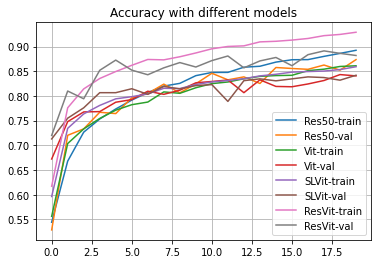

In [95]:
plt.plot(torch.tensor(save_acc1['train']))
plt.plot(torch.tensor(save_acc1['val']))
plt.plot(torch.tensor(save_acc2['train']))
plt.plot(torch.tensor(save_acc2['val']))
plt.plot(torch.tensor(save_acc3['train']))
plt.plot(torch.tensor(save_acc3['val']))
plt.plot(torch.tensor(save_acc4['train']))
plt.plot(torch.tensor(save_acc4['val']))
plt.legend(["Res50-train", "Res50-val", "Vit-train", "Vit-val", "SLVit-train", "SLVit-val", "ResVit-train", "ResVit-val"])
plt.title("Accuracy with different models")
plt.grid()

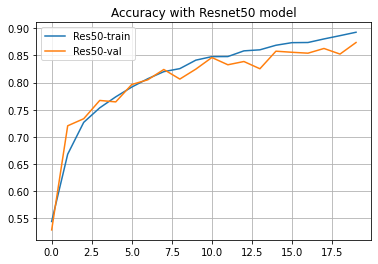

In [96]:
plt.plot(torch.tensor(save_acc1['train']))
plt.plot(torch.tensor(save_acc1['val']))
plt.legend(["Res50-train", "Res50-val"])
plt.title("Accuracy with Resnet50 model")
plt.grid()

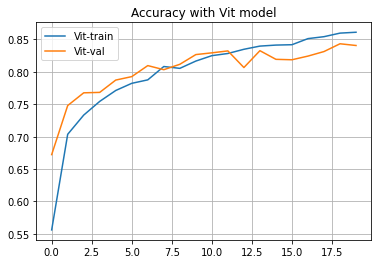

In [97]:
plt.plot(torch.tensor(save_acc2['train']))
plt.plot(torch.tensor(save_acc2['val']))
plt.legend(["Vit-train", "Vit-val"])
plt.title("Accuracy with Vit model")
plt.grid()

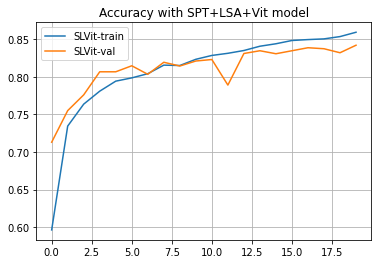

In [98]:
plt.plot(torch.tensor(save_acc3['train']))
plt.plot(torch.tensor(save_acc3['val']))
plt.legend(["SLVit-train", "SLVit-val"])
plt.title("Accuracy with SPT+LSA+Vit model")
plt.grid()

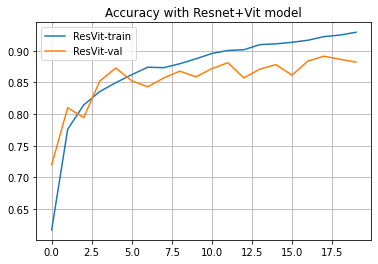

In [99]:
plt.plot(torch.tensor(save_acc4['train']))
plt.plot(torch.tensor(save_acc4['val']))
plt.legend(["ResVit-train", "ResVit-val"])
plt.title("Accuracy with Resnet+Vit model")
plt.grid()

###2.1.6 Test accuracy

In [100]:
test_loss1 = 0.0
test_acc1 = 0.0
tests(model_res_nonpre, test_loss1, test_acc1, testDataLoader)

Epoch:1 -- Phase:test -- Loss:0.38 -- Acc:87.37


In [101]:
test_loss2 = 0.0
test_acc2 = 0.0
tests(model_vit_nonpre, test_loss2, test_acc2, testDataLoader)

Epoch:1 -- Phase:test -- Loss:0.45 -- Acc:84.07


In [102]:
test_loss3 = 0.0
test_acc3 = 0.0
tests(model_lsv_nonpre, test_loss3, test_acc3, testDataLoader)

Epoch:1 -- Phase:test -- Loss:0.44 -- Acc:84.20


In [103]:
test_loss4 = 0.0
test_acc4 = 0.0
tests(model_resvit_nonpre, test_loss4, test_acc4, testDataLoader)

Epoch:1 -- Phase:test -- Loss:0.36 -- Acc:88.20
